# Notes

# Utils

In [49]:
import pandas as pd
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import word_tokenize
from mlxtend.preprocessing import TransactionEncoder
import numpy as np
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates

In [50]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kouro\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kouro\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [51]:
def correct_types(df, column='SO_Omschrijving'):
    """
    Preprocess the specified column in a DataFrame by replacing NaN values with an empty string
    and converting non-string values to string objects.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - column (str): The column to be preprocessed. Default is 'SO_Omschrijving'.

    Returns:
    - pd.DataFrame: The DataFrame with the specified column preprocessed.
    """

    df[column] = df[column].fillna('')
    df[column] = df[column].astype(str)
    return df

def replace_punctuation(text):
    """
    Replace punctuation in the input text.

    Parameters:
    - text (str): The input text in which punctuation will be replaced.

    Returns:
    - str: The input text with punctuation replaced.
    """
    # Replace "'s" with empty space.
    text = text.replace("'s", '')

    # Create a translation table to replace '.' and "'" with empty space, and other punctuation with spaces.
    translator = str.maketrans({'.': '', "'": '', **{p: ' ' for p in string.punctuation if p not in ['.', "'"]}})

    cleaned_text = text.translate(translator)

    return cleaned_text

def remove_numerical_values(text):
    """
    Remove numbers and model-related patterns from the input text.

    Parameters:
    - text (str): The input text from which numbers and model-related patterns will be removed.

    Returns:
    - str: The input text with numbers and model-related patterns removed.
    """
    # Remove standalone numbers with optional floating points; such as 154, 99.31.
    text = re.sub(r'\b\d+(\.\d+)?\b', '', text)

    # Remove ordinal numbers; such as 1e, 2ste, 3de, 4e.
    text = re.sub(r'\b\d+(e|ste|de|e)\b', '', text)

    # Remove numerical quantifiers; such as 1x OH.
    text = re.sub(r'\b\d+[xX]\b', '', text)

    return text

def stemize(text):
    """
    Perform stemming on the input text using the Dutch Snowball Stemmer.

    Parameters:
    - text (str): The input text to be stemmed.

    Returns:
    str: The stemmed text.

    Example:
    >>> stemize("This is an example text for stemming.")
    'thi is an exampl text for stem.'
    """
    stemmer = SnowballStemmer("dutch")
    tokens = word_tokenize(text)
    text = ' '.join([stemmer.stem(token) for token in tokens])
    return text

def normalize_lookups():
    """
    Normalize and preprocess the global lookup lists.

    This function performs the following operations on each global lookup list:
    1. Orders lookup lists by length in descending order.
    2. Initializes the Dutch Snowball Stemmer.
    3. Replaces punctuations using the `replace_punctuation` function.
    4. Removes numerical values using the `remove_numerical_values` function.
    5. Applies stemming using the `stemize` function.
    6. Converts the resulting list to a set.

    Note: The original lookup lists are modified in-place.

    Returns:
    None
    """
    # Get all lookup lists using regular expression.
    lookup_lists = [var for var in globals() if re.match(r'^lookup_', var)]

    # Initialize stemmer.
    # stemmer = SnowballStemmer("dutch")

    for lookup_list_name in lookup_lists:

        lookup_list = globals()[lookup_list_name]

        # Replace punctuations, remove numerical values, and apply stemming.
        normalized_list = [stemize(remove_numerical_values(replace_punctuation(word))) for word in lookup_list]

        # Convert to set.
        lookup_list.clear()
        lookup_list.extend(set(normalized_list))

def group_items(description):
    """
    Group items in a description based on predefined lookup lists.

    Parameters:
    - description (str): The input description to be categorized.

    Returns:
    str: The category type of the description based on predefined lookup lists.
         If no match is found, 'Unknown' is returned.

    Example:
    >>> group_items("This is a description containing cooling keywords.")
    'cooling'
    """
    # Get all lookup lists using regular expression.
    lookup_lists = [var for var in globals() if re.match(r'^lookup_', var)]

    # Order lookup lists by length in descending order.
    lookup_lists = sorted(lookup_lists, key=lambda x: len(globals()[x]), reverse=True)

    for lookup_list_name in lookup_lists:
        lookup_list = globals()[lookup_list_name]

        for word in lookup_list:
            if word in description:
                type_name = module_names[lookup_list_name.split('_')[1]]
                return type_name
    return 'Unknown'

def rules_to_coordinates(rules):
    """
    Convert association rules to coordinates.

    Parameters:
    - rules (pd.DataFrame): DataFrame containing association rules with 'antecedents', 'consequents', and other columns.

    Returns:
    - pd.DataFrame: DataFrame with 'antecedent', 'consequent', and 'rule' columns representing coordinates.
    """

    # Extract the first item from antecedents and consequents.
    rules['antecedent'] = rules['antecedents'].apply(lambda antecedent: list(antecedent)[0])
    rules['consequent'] = rules['consequents'].apply(lambda consequent: list(consequent)[0])

    # Assign rule index to a new column 'rule'.
    rules['rule'] = rules.index

    # Select relevant columns for coordinates.
    coords = rules[['antecedent', 'consequent', 'rule']]

    return coords

def contains_word_regex(sentence, target_word):
    """
    Check if a given word is present in a sentence using regex.

    Parameters:
    - sentence (str): The input sentence to check.
    - target_word (str): The word to look for in the sentence.

    Returns:
    - bool: True if the word is found, False otherwise.
    """
    # Construct a regex pattern to match the whole word, case-insensitive.
    pattern = r'\b' + re.escape(target_word) + r'\b'
    
    # Use re.search to find the pattern in the sentence.
    match = re.search(pattern, sentence, flags=re.IGNORECASE)
    
    # Return True if a match is found, False otherwise.
    return bool(match)

In [52]:
lookup_cooling = [
    "airco",
    "aircos",
    "drogekoeler",
    "koelmachine",
    "koeling",
    "KM",
    "koelunit",
    "koelinstallatie",
    "topcooling",
    "gkw",
    "koeltoren",
    "chillers",
    "drycooler",
    "koelplafond",
    "koelklep",
    "koelwaterpomp",
    "carrier",
    "DX koeler",
    "DXkoeler",
    "draaikoeler",
    "condensventilator",
    "chiller",
    "koelventilator",
    "Condensorventilator",
    "condenser"
]

module_names = {
    "complaints": "Complaints",
    "regularMaintenance": "Regular Maintenance",
    "faultRedemption": "Fault Redemption",
    "domesticWater": "Domestic Water",
    "office": "Office",
    "waterDistribution": "Water Distribution",
    "bms": "BMS",
    "wkk": "WKK",
    "elevator": "Elevator",
    "lighting": "Lighting",
    "heatPump": "Heat Pump",
    "sanitary": "Sanitary",
    "fireSafety": "Fire Safety",
    "shading": "Shading",
    "entrance": "Entrance",
    "cooling": "cooling",
    "heating": "Heating",
    "cooling": "Cooling"
}

# Data Reading

In [53]:
path = './Navision Serviceorder data.xlsx'

# Read the Excel file into a DataFrame.
df_so = pd.read_excel(path)
df_so.reset_index(drop=True, inplace=True)
columns_to_select = ['SO_Omschrijving', 'SO_Orderdatum (Begindatum)', 'Order technisch gereed (Einddatum)', 'Factuurkosten SO']
df_so = df_so[columns_to_select]

# This dataframe is used for testing purposes.
df_original = df_so.copy()
df_original.reset_index(drop=True, inplace=True)
columns_to_select = ['SO_Omschrijving', 'SO_Orderdatum (Begindatum)', 'Order technisch gereed (Einddatum)', 'Factuurkosten SO']
df_original = df_original[columns_to_select]


# Data Cleaning

In [54]:
# Create a copy from the original dataset.
df_so_cleaned = correct_types(df_so, column='SO_Omschrijving')

# Replace punctuations.
df_so_cleaned['SO_Omschrijving'] = df_so_cleaned['SO_Omschrijving'].apply(replace_punctuation)

# Remove numerical values.
df_so_cleaned['SO_Omschrijving'] = df_so_cleaned['SO_Omschrijving'].apply(remove_numerical_values)

# Remove Dutch stop words.
stop_words = set(stopwords.words('dutch'))
stop_words.add('via')
stop_words.discard('niet')
df_so_cleaned['SO_Omschrijving'] = df_so_cleaned['SO_Omschrijving'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in stop_words]))

# Stemize the text.
df_so_cleaned['SO_Omschrijving'] = df_so_cleaned['SO_Omschrijving'].apply(stemize)

df_so_cleaned.head()

,SO_Omschrijving,SO_Orderdatum (Begindatum),Order technisch gereed (Einddatum),Factuurkosten SO
0,storing stoombevochtiger ruimt,44608,44609.0,154.18
1,wasbak pantry ruimt loopt slecht,44624,44624.0,229.58
2,storing bevochtiger lbk link,44627,44628.0,188.14
3,afzuig schakelar werkt niet keuk,44704,44704.0,250.17
4,snaarbreuk afzuigvent lbk recht,44742,44746.0,447.16


# Modules Grouping

In [55]:
df_so_cleaned['target'] = df_so_cleaned['SO_Omschrijving'].apply(group_items)
categorized_count = 0
for _, value in module_names.items():
    categorized_count = categorized_count + len(df_so_cleaned["target"][df_so_cleaned["target"] == value])
    print(f'{value} count: {len(df_so_cleaned["target"][df_so_cleaned["target"] == value])}')

Complaints count: 0
Regular Maintenance count: 0
Fault Redemption count: 0
Domestic Water count: 0
Office count: 0
Water Distribution count: 0
BMS count: 0
WKK count: 0
Elevator count: 0
Lighting count: 0
Heat Pump count: 0
Sanitary count: 0
Fire Safety count: 0
Shading count: 0
Entrance count: 0
Cooling count: 805
Heating count: 0


In [56]:
df_so_cooling = df_so_cleaned[df_so_cleaned["target"].isin(["Cooling"])]
df_so_cooling.head()

,SO_Omschrijving,SO_Orderdatum (Begindatum),Order technisch gereed (Einddatum),Factuurkosten SO,target
25,computair ruimt koeling plas water server,45140,45148.0,218.68,Cooling
59,airco unit lijkt strom krijg,43735,NaN,0.00,Cooling
60,lekkag airco binnendel,43735,43749.0,702.68,Cooling
79,secundair koeling doet,44055,44670.0,1336.20,Cooling
88,koeling blaast koud lucht,44351,44375.0,972.29,Cooling


# Preparation

In [57]:
# Split transaction strings into lists.
transactions = df_so_cooling['SO_Omschrijving'].apply(lambda t: t.split(' '))

# Convert DataFrame column into list of strings.
transactions_cooling = list(transactions)

print(transactions_cooling)

[['computair', 'ruimt', 'koeling', 'plas', 'water', 'server'], ['airco', 'unit', 'lijkt', 'strom', 'krijg'], ['lekkag', 'airco', 'binnendel'], ['secundair', 'koeling', 'doet'], ['koeling', 'blaast', 'koud', 'lucht'], ['koeling', 'blaast', 'koud', 'lucht'], ['koeling', 'dak', 'werkt', 'niet'], ['koeling', 'dak', 'werkt', 'niet'], ['iv', 'airco', 'defect'], ['jb', 'lekkag', 'koelplafond', 'verd'], ['jh', 'airco', 'defect'], ['koelinstallatie', 'stat', 'alarm', 'cod', 'e0003'], ['koelplafond', 'voel', 'niet', 'koud'], ['nieuw', 'geplaatst', 'koeling', 'ruitjes', 'afstell', 'hog'], ['beid', 'koelmachines', 'stan', 'storing', 'urgentie', 'hog'], ['storing', 'koeling'], ['koeling', 'storing'], ['beid', 'koelinstallaties', 'storing'], ['lekkag', 'leiding', 'airco', 'verdiep', 'afd', 'gegevensb'], ['gkw', 'lekkag', 'drukvat'], ['groep', 'airco', 'valt'], ['airco', 'portierslog', 'storing'], ['lekkag', 'restaurant', 'airco', 'plafond'], ['lekkag', 'restaurant', 'airco', 'plafond'], ['lekkag', '

In [58]:
# Instantiate transaction encoder and identify unique items in transactions.
encoder = TransactionEncoder().fit(transactions_cooling)

# One-hot encode transactions.
onehot_cooling = encoder.transform(transactions_cooling)
onehot_cooling = pd.DataFrame(onehot_cooling, columns=encoder.columns_)

# Algorithm

**Itemsets Creation**

In [59]:
# Compute frequent itemsets using the Apriori algorithm.
n = 1
frequent_itemsets_cooling = apriori(onehot_cooling, 
                            min_support =  n/len(onehot_cooling),  #Has happened at least in n transactions.
                            use_colnames = True,
                            verbose = 1)

print(f'Number of transactions: {len(onehot_cooling)}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_cooling)}')

frequent_itemsets_cooling = frequent_itemsets_cooling.sort_values(by=['support'], ascending=False).reset_index(drop=True)
length_1 = len(frequent_itemsets_cooling[frequent_itemsets_cooling['itemsets'].apply(lambda x: len(x)) == 1])
length_2 = len(frequent_itemsets_cooling[frequent_itemsets_cooling['itemsets'].apply(lambda x: len(x)) == 2])
length_3 = len(frequent_itemsets_cooling[frequent_itemsets_cooling['itemsets'].apply(lambda x: len(x)) == 3])
length_more_than_3 = len(frequent_itemsets_cooling[frequent_itemsets_cooling['itemsets'].apply(lambda x: len(x)) > 3])
print(f'Number of frequent itemsets with length 1: {length_1}')
print(f'Number of frequent itemsets with length 2: {length_2}')
print(f'Number of frequent itemsets with length 3: {length_3}')
print(f'Number of frequent itemsets with length more than 3: {length_more_than_3}')
frequent_itemsets_cooling.head()

Processing 45 combinations | Sampling itemset size 9 8765
Number of transactions: 805
Number of frequent itemsets: 13274
Number of frequent itemsets with length 1: 730
Number of frequent itemsets with length 2: 3218
Number of frequent itemsets with length 3: 4498
Number of frequent itemsets with length more than 3: 4828


,support,itemsets
0,0.618634,(airco)
1,0.295652,(storing)
2,0.242236,(koeling)
3,0.191304,(niet)
4,0.183851,"(airco, storing)"


**Rules Creation**

In [60]:
# Compute all association rules for frequent_itemsets.
rules_cooling = association_rules(frequent_itemsets_cooling, 
                            metric = "lift", 
                         	min_threshold = 1)

rules_cooling = rules_cooling.sort_values(by=['support'], ascending=False).reset_index(drop=True)
print(f'Number of frequent itemsets: {len(frequent_itemsets_cooling)}')
print(f'Number of rules: {len(rules_cooling)}')
rules_cooling.head(50)

Number of frequent itemsets: 13274
Number of rules: 144176


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(airco),(storing),0.618634,0.295652,0.183851,0.297189,1.005197,0.000951,1.002186,0.013558
1,(storing),(airco),0.295652,0.618634,0.183851,0.621849,1.005197,0.000951,1.008502,0.007341
2,(airco),(niet),0.618634,0.191304,0.125466,0.202811,1.060150,0.007119,1.014434,0.148773
3,(niet),(airco),0.191304,0.618634,0.125466,0.655844,1.060150,0.007119,1.108121,0.070159
4,(werkt),(niet),0.114286,0.191304,0.113043,0.989130,5.170455,0.091180,74.400000,0.910670
5,(niet),(werkt),0.191304,0.114286,0.113043,0.590909,5.170455,0.091180,2.165079,0.997400
6,(airco),(werkt),0.618634,0.114286,0.072050,0.116466,1.019076,0.001349,1.002468,0.049085
7,(werkt),(airco),0.114286,0.618634,0.072050,0.630435,1.019076,0.001349,1.031933,0.021135
8,"(airco, werkt)",(niet),0.072050,0.191304,0.072050,1.000000,5.227273,0.058266,inf,0.871486
9,"(airco, niet)",(werkt),0.125466,0.114286,0.072050,0.574257,5.024752,0.057711,2.080399,0.915899


**Test Section**

In [61]:
rule_index = 3
word_list = list(rules_cooling.iloc[rule_index]['antecedents'])
word_list.extend(list(rules_cooling.iloc[rule_index]['consequents']))
indices = []
for transaction in df_so['SO_Omschrijving']:
    if all(contains_word_regex(transaction, word) for word in word_list):
        indices.append(df_so[df_so['SO_Omschrijving'] == transaction].index[0])

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f"Original Dataset: {len(indices)} items\n{df_original.iloc[indices]['SO_Omschrijving']}")
    print(f"\nCleaned Dataset: {len(indices)} items\n{df_so.iloc[indices]['SO_Omschrijving']}")

Original Dataset: 101 items
1106                         airco kantoor TD doet het niet
1230              Airco kantoor " Kruidenier" wil niet aan.
1291         Airco werkt niet bij kantoor Otto/hoofdingang.
1469                (RA) Airco kassameubel koelt niet meer.
1822                       Storing airco kantine werkt niet
1830                      * Airco koelt niet goed en lekt. 
1974                Storing airco kantine, reset werkt niet
1982                      Airco in het Wap koelt niet meer 
2221                                   (MP)Airco werkt niet
2226        airco werkt wederom niet display geeft niks aan
2237                         Storing airco, koelt niet meer
3094                       Airco ruimte RN224 gaat niet aan
3321                                 (RA) Airco werkt niet.
3484        (RA) Airco unit in het nwe gedeelte werkt niet.
3488            (RA) Airco reageert niet meer op bediening.
3675                   Airco in de afnameruimte werkt niet 
4840        

# Analysis

In [62]:
df_original = pd.read_excel(path)
df_original.reset_index(drop=True, inplace=True)
columns_to_select = ['SO_Omschrijving', 'SO_Orderdatum (Begindatum)', 'Order technisch gereed (Einddatum)', 'Factuurkosten SO']
df_original = df_original[columns_to_select]

In [ ]:
flag = rules_cooling[rules_cooling['lift'] < 1].copy()
print(len(flag))

0


In [ ]:
rules_one_consequent = rules_cooling[rules_cooling['antecedents'].apply(len) == 2]
print(len(rules_one_consequent))
rules_one_consequent.head(60)

51389


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
8,"(airco, werkt)",(niet),0.072050,0.191304,0.072050,1.000000,5.227273,0.058266,inf,0.871486
9,"(airco, niet)",(werkt),0.125466,0.114286,0.072050,0.574257,5.024752,0.057711,2.080399,0.915899
10,"(werkt, niet)",(airco),0.113043,0.618634,0.072050,0.637363,1.030275,0.002117,1.051647,0.033130
31,"(koeling, niet)",(werkt),0.059627,0.114286,0.039752,0.666667,5.833333,0.032937,2.657143,0.881110
32,"(werkt, niet)",(koeling),0.113043,0.242236,0.039752,0.351648,1.451677,0.012368,1.168755,0.350797
33,"(werkt, koeling)",(niet),0.040994,0.191304,0.039752,0.969697,5.068871,0.031909,26.686957,0.837030
68,"(airco, niet)",(goed),0.125466,0.023602,0.017391,0.138614,5.872850,0.014430,1.133519,0.948762
69,"(airco, goed)",(niet),0.017391,0.191304,0.017391,1.000000,5.227273,0.014064,inf,0.823009
71,"(goed, niet)",(airco),0.023602,0.618634,0.017391,0.736842,1.191080,0.002790,1.449193,0.164304
72,"(airco, ruimt)",(storing),0.040994,0.295652,0.016149,0.393939,1.332442,0.004029,1.162174,0.260163


In [ ]:
word_list = list(rules_cooling.iloc[0]['antecedents'])
indices = []
for transaction in df_so['SO_Omschrijving']:
    if all(contains_word_regex(transaction, word) for word in word_list):
        indices.append(df_so[df_so['SO_Omschrijving'] == transaction].index[0])

with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(f"Original Dataset: {len(indices)} items\n{df_original.iloc[indices]['SO_Omschrijving']}")
    print(f"\nCleaned Dataset: {len(indices)} items\n{df_so.iloc[indices]['SO_Omschrijving']}")

Original Dataset: 498 items
59                  Airco-unit lijkt geen stroom te krijgen
60                                 lekkage airco binnendeel
153                                 (IV) De airco is defect
340                                       (JH) airco defect
988      Lekkage leiding airco 1e verdieping afd gegevensb.
1014                              Groep van airco valt uit.
1015                          Airco portiersloge op storing
1025                       Lekkage restaurant airco plafond
1025                       Lekkage restaurant airco plafond
1025                       Lekkage restaurant airco plafond
1053                         storing airco, hoger afzekeren
1055                                          storing airco
1053                         storing airco, hoger afzekeren
1091                             (JB) Wederom airco storing
1100                     (MP) Airco serverruimte in storing
1102            (MP) Storing airco's kantine/vergaderruimte
1106        

# Visualization

**Heatmap**

Processing 567 combinations | Sampling itemset size 3
number of frequent itemsets: 55
Number of rules: 60


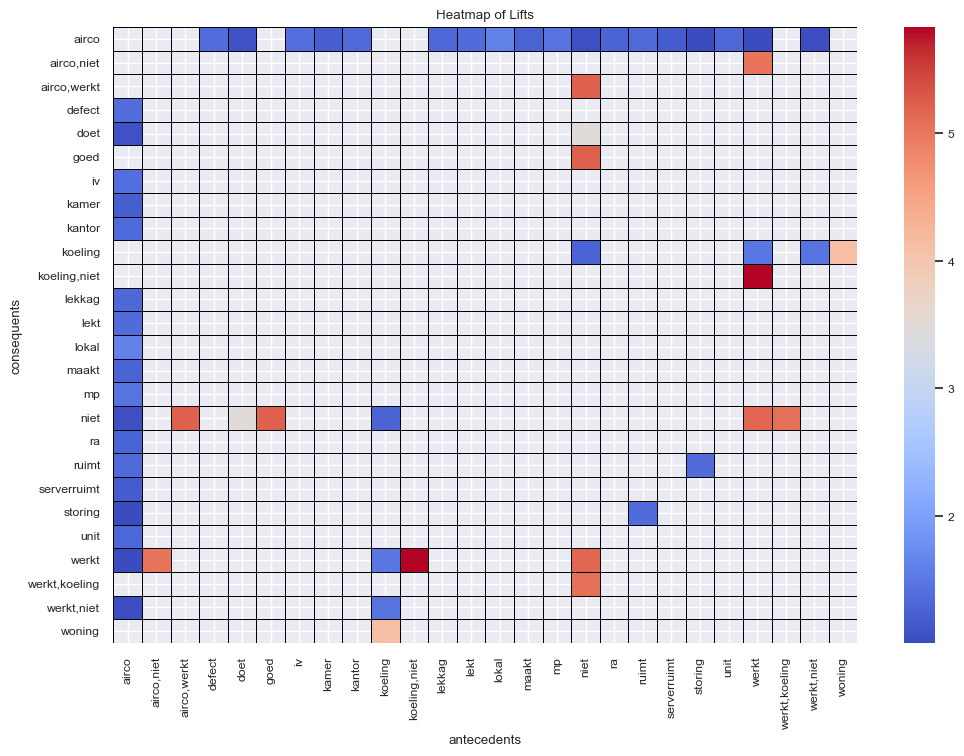

In [ ]:
frequent_itemsets_cooling = apriori(onehot_cooling, 
                            min_support =  15/len(onehot_cooling),
                            use_colnames = True,
                            verbose = 1)

rules_cooling = association_rules(frequent_itemsets_cooling, metric = 'lift', min_threshold = 1)

print(f'number of frequent itemsets: {len(frequent_itemsets_cooling)}')
print(f'Number of rules: {len(rules_cooling)}')

# Replace frozen sets with strings.
rules_cooling['antecedents'] = rules_cooling['antecedents'].apply(lambda a: ','.join(list(a)))
rules_cooling['consequents'] = rules_cooling['consequents'].apply(lambda a: ','.join(list(a)))

# Transform data to matrix format and generate heatmap.
pivot = rules_cooling.pivot(index='consequents', columns='antecedents', values='lift')
sns.set(font_scale=0.8)  # Adjust the font size as needed
plt.figure(figsize=(12, 8))  # Adjust width and height as needed
sns.heatmap(pivot, cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='black')

plt.title('Heatmap of Lifts')
plt.yticks(rotation=0)
plt.show()

**Antecedent-Consequent Support Scatterplot**

Processing 45 combinations | Sampling itemset size 9 8765
Number of transactions: 805
Number of frequent itemsets: 13274
Minimum support: 0.0012422360248447205
Number of rules: 144176


<Axes: xlabel='antecedent support', ylabel='consequent support'>

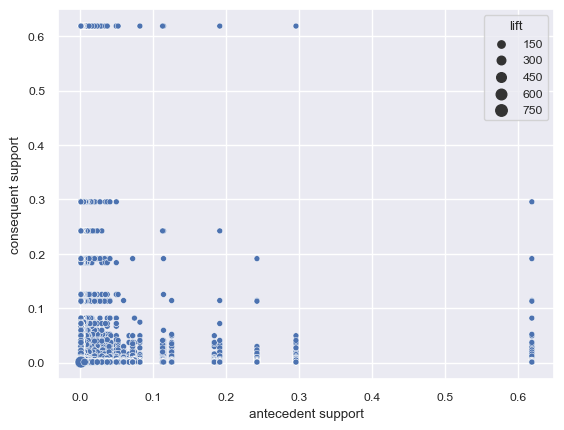

In [ ]:
# Compute frequent itemsets using the Apriori algorithm.
frequent_itemsets_cooling = apriori(onehot_cooling, 
                            min_support =  0.000001, # Happenning at least 10 times.
                            use_colnames = True,
                            verbose = 1)

print(f'Number of transactions: {len(onehot_cooling)}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_cooling)}')

rules_cooling = association_rules(frequent_itemsets_cooling, metric = 'lift', min_threshold = 1)
print(f"Minimum support: {rules_cooling['support'].min()}")

print(f'Number of rules: {len(rules_cooling)}')

sns.scatterplot(x='antecedent support', y='consequent support', size='lift', data=rules_cooling)

**Support-Confidence Scatterplot**

Processing 45 combinations | Sampling itemset size 9 8765
Number of transactions: 805
Number of frequent itemsets: 13274
Number of rules: 0


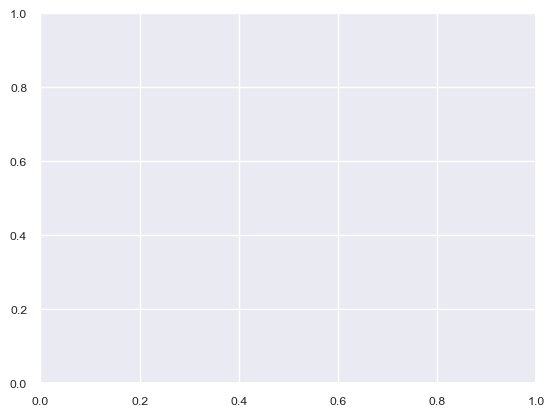

In [ ]:
# Compute frequent itemsets using the Apriori algorithm.
frequent_itemsets_cooling = apriori(onehot_cooling, 
                            min_support =  0.00000000001,
                            use_colnames = True,
                            verbose = 1)

print(f'Number of transactions: {len(onehot_cooling)}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_cooling)}')

rules_cooling = association_rules(frequent_itemsets_cooling, metric = 'support', 
                          min_threshold = 1)

print(f'Number of rules: {len(rules_cooling)}')

sns.scatterplot(x = "support", y = "confidence", data = rules_cooling)
plt.show()

**Support-Lift Scatterplot**

Processing 72 combinations | Sampling itemset size 4 3
Number of transactions: 805
Number of frequent itemsets: 98
Number of rules: 162


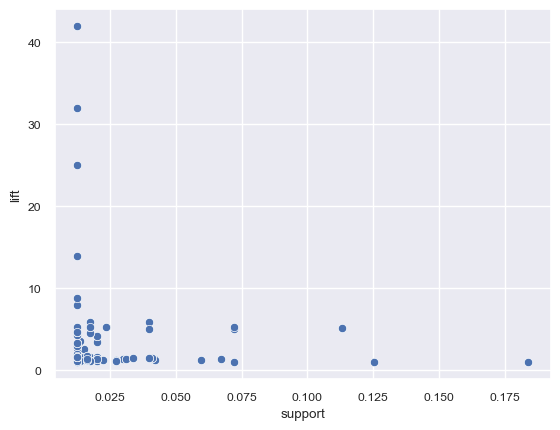

In [ ]:
n = 10

frequent_itemsets_cooling = apriori(onehot_cooling, 
                            min_support =  n/len(onehot_cooling),  #Has happened at least in n transactions.
                            use_colnames = True,
                            verbose = 1)

print(f'Number of transactions: {len(onehot_cooling)}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_cooling)}')

rules_cooling = association_rules(frequent_itemsets_cooling, metric = 'lift', 
                          min_threshold = 1)

print(f'Number of rules: {len(rules_cooling)}')

sns.scatterplot(x = "support", y = "lift", data = rules_cooling)
plt.show()

**Parallel-Coordinates Plot**

Processing 567 combinations | Sampling itemset size 3
Number of transactions: 805
Number of frequent itemsets: 55
Number of rules: 60


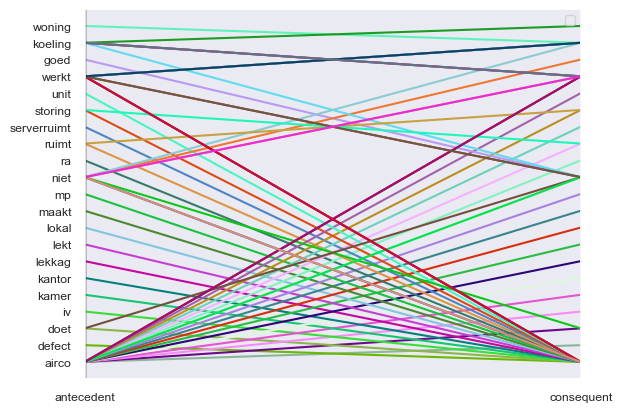

In [ ]:
n = 15

frequent_itemsets_cooling = apriori(onehot_cooling, 
                            min_support =  n/len(onehot_cooling),  #Has happened at least in n transactions.
                            use_colnames = True,
                            verbose = 1)

rules_cooling = association_rules(frequent_itemsets_cooling, metric = 'lift', 
                          min_threshold = 1)

print(f'Number of transactions: {len(onehot_cooling)}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_cooling)}')
print(f'Number of rules: {len(rules_cooling)}')


# Convert rules into coordinates suitable for use in a parallel coordinates plot.
coords = rules_to_coordinates(rules_cooling)

# Generate parallel coordinates plot
parallel_coordinates(coords, 'rule')
plt.legend([])
plt.show()

# Final Result

In [ ]:
# Finding frequent itemsets.
min_support = 15 / len(onehot_cooling)
frequent_itemsets_cooling = apriori(onehot_cooling, 
                                        min_support=min_support,
                                        use_colnames=True,
                                        verbose=1)

# Generating association rules.
rules_cooling = association_rules(frequent_itemsets_cooling, 
                                       metric='lift', 
                                       min_threshold=1)

# Displaying information.
num_transactions = len(onehot_cooling)
print(f'Number of transactions: {num_transactions}')
print(f'Minimum itemset support: {min_support}')
print(f'Number of frequent itemsets: {len(frequent_itemsets_cooling)}')
print(f'Number of association rules: {len(rules_cooling)}')

# Removing duplicate rules.
duplicates = set()
for i, row in rules_cooling.iterrows():
    antecedent = row['antecedents']
    consequent = row['consequents']
    for j, r in rules_cooling.iloc[i+1:].iterrows():
        if consequent.union(antecedent) == r['antecedents'].union(r['consequents']):
            duplicates.add(j)

rules_cooling.drop(index=duplicates, inplace=True)
rules_cooling.reset_index(drop=True, inplace=True)
rules_cooling = rules_cooling.sort_values(by='support', ascending=False).reset_index(drop=True)

print(f'Number of real rules: {len(rules_cooling)}')
rules_cooling

Processing 567 combinations | Sampling itemset size 3
Number of transactions: 805
Minimum itemset support: 0.018633540372670808
Number of frequent itemsets: 55
Number of association rules: 60
Number of real rules: 26


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(airco),(storing),0.618634,0.295652,0.183851,0.297189,1.005197,0.000951,1.002186,0.013558
1,(airco),(niet),0.618634,0.191304,0.125466,0.202811,1.060150,0.007119,1.014434,0.148773
2,(werkt),(niet),0.114286,0.191304,0.113043,0.989130,5.170455,0.091180,74.400000,0.910670
3,"(airco, werkt)",(niet),0.072050,0.191304,0.072050,1.000000,5.227273,0.058266,inf,0.871486
4,(airco),(werkt),0.618634,0.114286,0.072050,0.116466,1.019076,0.001349,1.002468,0.049085
5,(lekkag),(airco),0.081988,0.618634,0.067081,0.818182,1.322563,0.016360,2.097516,0.265674
6,(koeling),(niet),0.242236,0.191304,0.059627,0.246154,1.286713,0.013287,1.072760,0.294057
7,(airco),(defect),0.618634,0.049689,0.042236,0.068273,1.373996,0.011496,1.019945,0.713738
8,(airco),(unit),0.618634,0.052174,0.042236,0.068273,1.308568,0.009959,1.017279,0.618318
9,(airco),(ruimt),0.618634,0.049689,0.040994,0.066265,1.333584,0.010254,1.017752,0.655908


In [ ]:
rule_indices = list(range(0, len(rules_cooling)))
rule_indices

# Set the maximum width of the columns.
pd.set_option('display.max_colwidth', None)

for row_index in rule_indices:
    word_list = list(rules_cooling.iloc[row_index]['antecedents'])
    word_list.extend(list(rules_cooling.iloc[row_index]['consequents']))
    indices = []
    for transaction in df_so['SO_Omschrijving']:
        if all(contains_word_regex(transaction, word) for word in word_list):
            indices.append(df_so[df_so['SO_Omschrijving'] == transaction].index[0])

    with pd.option_context('display.max_rows', None, 'display.max_columns', None):
        print(f"Original Dataset: {len(indices)} items\n{df_original.iloc[indices]['SO_Omschrijving']}")
        print(f"\nCleaned Dataset: {len(indices)} items\n{df_so.iloc[indices]['SO_Omschrijving']}\n\n")

Original Dataset: 148 items
1015                          Airco portiersloge op storing
1053                         storing airco, hoger afzekeren
1055                                          storing airco
1053                         storing airco, hoger afzekeren
1091                             (JB) Wederom airco storing
1100                     (MP) Airco serverruimte in storing
1102            (MP) Storing airco's kantine/vergaderruimte
1110                         storing airco dames kleedkamer
1113                                     (MP) storing airco
1113                                     (MP) storing airco
1115                 (MP) Storing airco spoelkeuken/kantoor
1129                            storing airco ruimte V2.38A
1134           storing airco restaurant en de vergaderzalen
1151                             storing airco melding CH61
1152                   Storing airco, (bezoek o.a. 6 juni) 
1155        Airco storing in de spoelkeuken, storing: CH61.
1055        